## Dynamic Meter Baseline Notebook

In [224]:
# Hearst BigQuery Data Importer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
import xgboost as xgb

## Linear Regression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

In [225]:
df = pd.read_csv('model_df_0329_sample.csv')
X = df.drop(columns = ['unique_visitor_id', 'days_to_subscription', 'has_subscribed'])
y = df['has_subscribed']

In [226]:
df.head()

,unique_visitor_id,percent_of_pageview_in_DMA,percent_pageview_counts_from_article,percent_time_on_site_from_article,days_to_subscription,days_since_first_pageview,days_since_last_pageview,recency_ratio,total_pageview_counts,percent_pageview_counts_from_device_mobile_phone,...,percent_pageview_counts_from_content_business_industrial,percent_time_spent_on_content_null,percent_time_spent_on_content_news,percent_time_spent_on_content_sensitive_subjects,percent_time_spent_on_content_sports,percent_time_spent_on_content_food_drink,percent_time_spent_on_content_law_government,percent_time_spent_on_content_jobs_education,percent_time_spent_on_content_business_industrial,has_subscribed
0,65195311-7562394252569080026,0.25,0.500000,0.767485,NaN,59,51,376.125,8,0.0,...,NaN,0.232515,NaN,0.249016,NaN,NaN,NaN,NaN,NaN,0
1,65195311-1777229465575295678,1.00,0.333333,0.272727,NaN,32,18,192.000,3,0.0,...,NaN,0.727273,NaN,NaN,NaN,NaN,0.272727,NaN,NaN,0
2,65195311-8125490054488688187,1.00,1.000000,1.000000,NaN,72,72,5184.000,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,65195311-3342248039944515107,0.00,1.000000,1.000000,NaN,0,0,NaN,2,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
4,65195311-854183054555717188,1.00,1.000000,1.000000,NaN,36,36,648.000,2,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [227]:
def get_data_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Get data summary diagnosis including # of missing,
    # of unique values, entropy, etc.
    Args:
        df (pd.DataFrame): Dataframe to inspect
    Returns:
        summary (pd.DataFrame): summary dataframe for the diagnosis
    """

    ## Start getting data summary
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summary = summary.reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name", "dtypes"]]
    summary["Missing"] = df.isnull().sum().values
    summary["Missing %"] = 100 * df.isnull().sum().values / len(df)
    summary['Variance'] = df.var().values
    summary["Uniques"] = df.nunique().values
    summary["First Value"] = df.loc[0].values
    summary["Second Value"] = df.loc[1].values
    summary["Third Value"] = df.loc[2].values

    return summary


In [228]:
summary = get_data_summary(X)
summary

Dataset Shape: (2351946, 129)


,Name,dtypes,Missing,Missing %,Variance,Uniques,First Value,Second Value,Third Value
0,percent_of_pageview_in_DMA,float64,0,0.000000,0.245552,1335,0.250000,1.000000,1.0
1,percent_pageview_counts_from_article,float64,0,0.000000,0.116215,2093,0.500000,0.333333,1.0
2,percent_time_on_site_from_article,float64,0,0.000000,0.118429,83766,0.767485,0.272727,1.0
3,days_since_first_pageview,int64,0,0.000000,698.315277,87,59.000000,32.000000,72.0
4,days_since_last_pageview,int64,0,0.000000,704.499395,87,51.000000,18.000000,72.0
...,...,...,...,...,...,...,...,...,...
124,percent_time_spent_on_content_sports,float64,1977179,84.065663,0.090137,34461,NaN,NaN,NaN
125,percent_time_spent_on_content_food_drink,float64,2146017,91.244314,0.120612,29694,NaN,NaN,NaN
126,percent_time_spent_on_content_law_government,float64,2166739,92.125372,0.112006,24399,NaN,0.272727,NaN
127,percent_time_spent_on_content_jobs_education,float64,2210213,93.973799,0.116679,22640,NaN,NaN,NaN


In [229]:
## Just for testing purposes. 
## We should think more clearly about what to drop / not to drop 
drop_columns = ['total_pageview_counts', 'total_time_on_site', 'avg_time_spent_on_site',
                'days_since_first_pageview',
                'percent_time_spent_on_device_mobile_phone',
               'percent_time_spent_on_device_mobile_desktop',
               'percent_time_spent_on_device_mobile_tablet',
               'percent_time_spent_on_browser_edge',
               'percent_time_spent_on_browser_android_webview',
               'percent_time_spent_on_browser_android_firefox',
               'percent_time_spent_on_browser_android_safari',
               'percent_time_spent_on_browser_safari_in_app',
               'percent_time_spent_on_browser_chrome',
               'percent_time_spent_on_source_newsletter',
                'percent_time_spent_on_source_direct',
               'percent_time_spent_on_source_paid_search',
               'percent_time_spent_on_source_hearst_site',
               'percent_time_spent_on_source_referral',
               'percent_time_spent_on_source_organic_search',
               'percent_time_spent_on_source_social_network',
               'percent_time_spent_on_weekend', 'percent_time_spent_on_weekday',
               'percent_time_spent_on_midnight', 'percent_time_spent_on_morning',
               'percent_time_spent_on_afternoon', 'percent_time_spent_on_evening',
                'percent_time_spent_on_content_null',
               'percent_time_spent_on_content_news',
               'percent_time_spent_on_content_sensitive_subjects',
               'percent_time_spent_on_content_sports',
               'percent_time_spent_on_content_food_drink',
               'percent_time_spent_on_content_law_government',
               'percent_time_spent_on_content_jobs_education',
               'percent_time_spent_on_content_business_industrial',
                'percent_time_on_site_from_article',
               'avg_pageview_per_day_from_device_mobile_phone',
               'avg_pageview_per_day_from_device_desktop',
               'avg_pageview_per_day_from_device_tablet',
               'avg_pageview_per_day_from_browser_edge',
               'avg_pageview_per_day_from_browser_android_webview',
               'avg_pageview_per_day_from_browser_firefox',
               'avg_pageview_per_day_from_browser_safari',
               'avg_pageview_per_day_from_browser_safari_in_app',
               'avg_pageview_per_day_from_source_newsletter',
               'avg_pageview_per_day_from_source_direct',
               'avg_pageview_per_day_from_source_paid_search',
               'avg_pageview_per_day_from_source_hearst_site',
               'avg_pageview_per_day_from_source_referral',
               'avg_pageview_per_day_from_source_organic_search',
               'avg_pageview_per_day_from_source_social_network',
               'avg_pageview_per_day_from_weekend',
               'avg_pageview_per_day_from_weekday',
               'avg_pageview_per_day_from_midnight',
               'avg_pageview_per_day_from_morning',
               'avg_pageview_per_day_from_afternoon',
               'avg_pageview_per_day_from_evening',
               'avg_pageview_per_day_from_content_null',
               'avg_pageview_per_day_from_content_news',
               'avg_pageview_per_day_from_content_sensitive_subjects',
               'avg_pageview_per_day_from_content_sports',
               'avg_pageview_per_day_from_content_food_drink',
               'avg_pageview_per_day_from_content_law_government',
               'avg_pageview_per_day_from_content_jobs_education',
               'avg_pageview_per_day_from_content_business_industrial',
               'avg_time_spent_on_content_null',
               'percent_pageview_counts_from_content_null']


X = X.drop(columns = drop_columns)

In [230]:
X.shape

(2351946, 63)

### Feature Correlation Inspection

#### Heatmap

In [231]:
def plot_heatmap(df, threshold=0, figsize=(20, 20)):
    """Generate heatmap to visualize correlation among numerical features
    Args:
        df: (pd.DataFrame)
            dataframe to plot heat map on
        threshold: (float)
            threshold for the heatmap to filter based on in terms of magnitude
        figsize: (int, int)
            figsize for the visualization
    """
    # Generate correlation data
    corr = df.corr()

    # Create mask
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr[(corr >= abs(threshold)) | (corr <= -abs(threshold))],
        # annot=True,
        cmap="RdBu",
        mask=mask,
        # annot_kws={"size": 8},
        cbar_kws={"label": "color bar"},
    )
    plt.show()

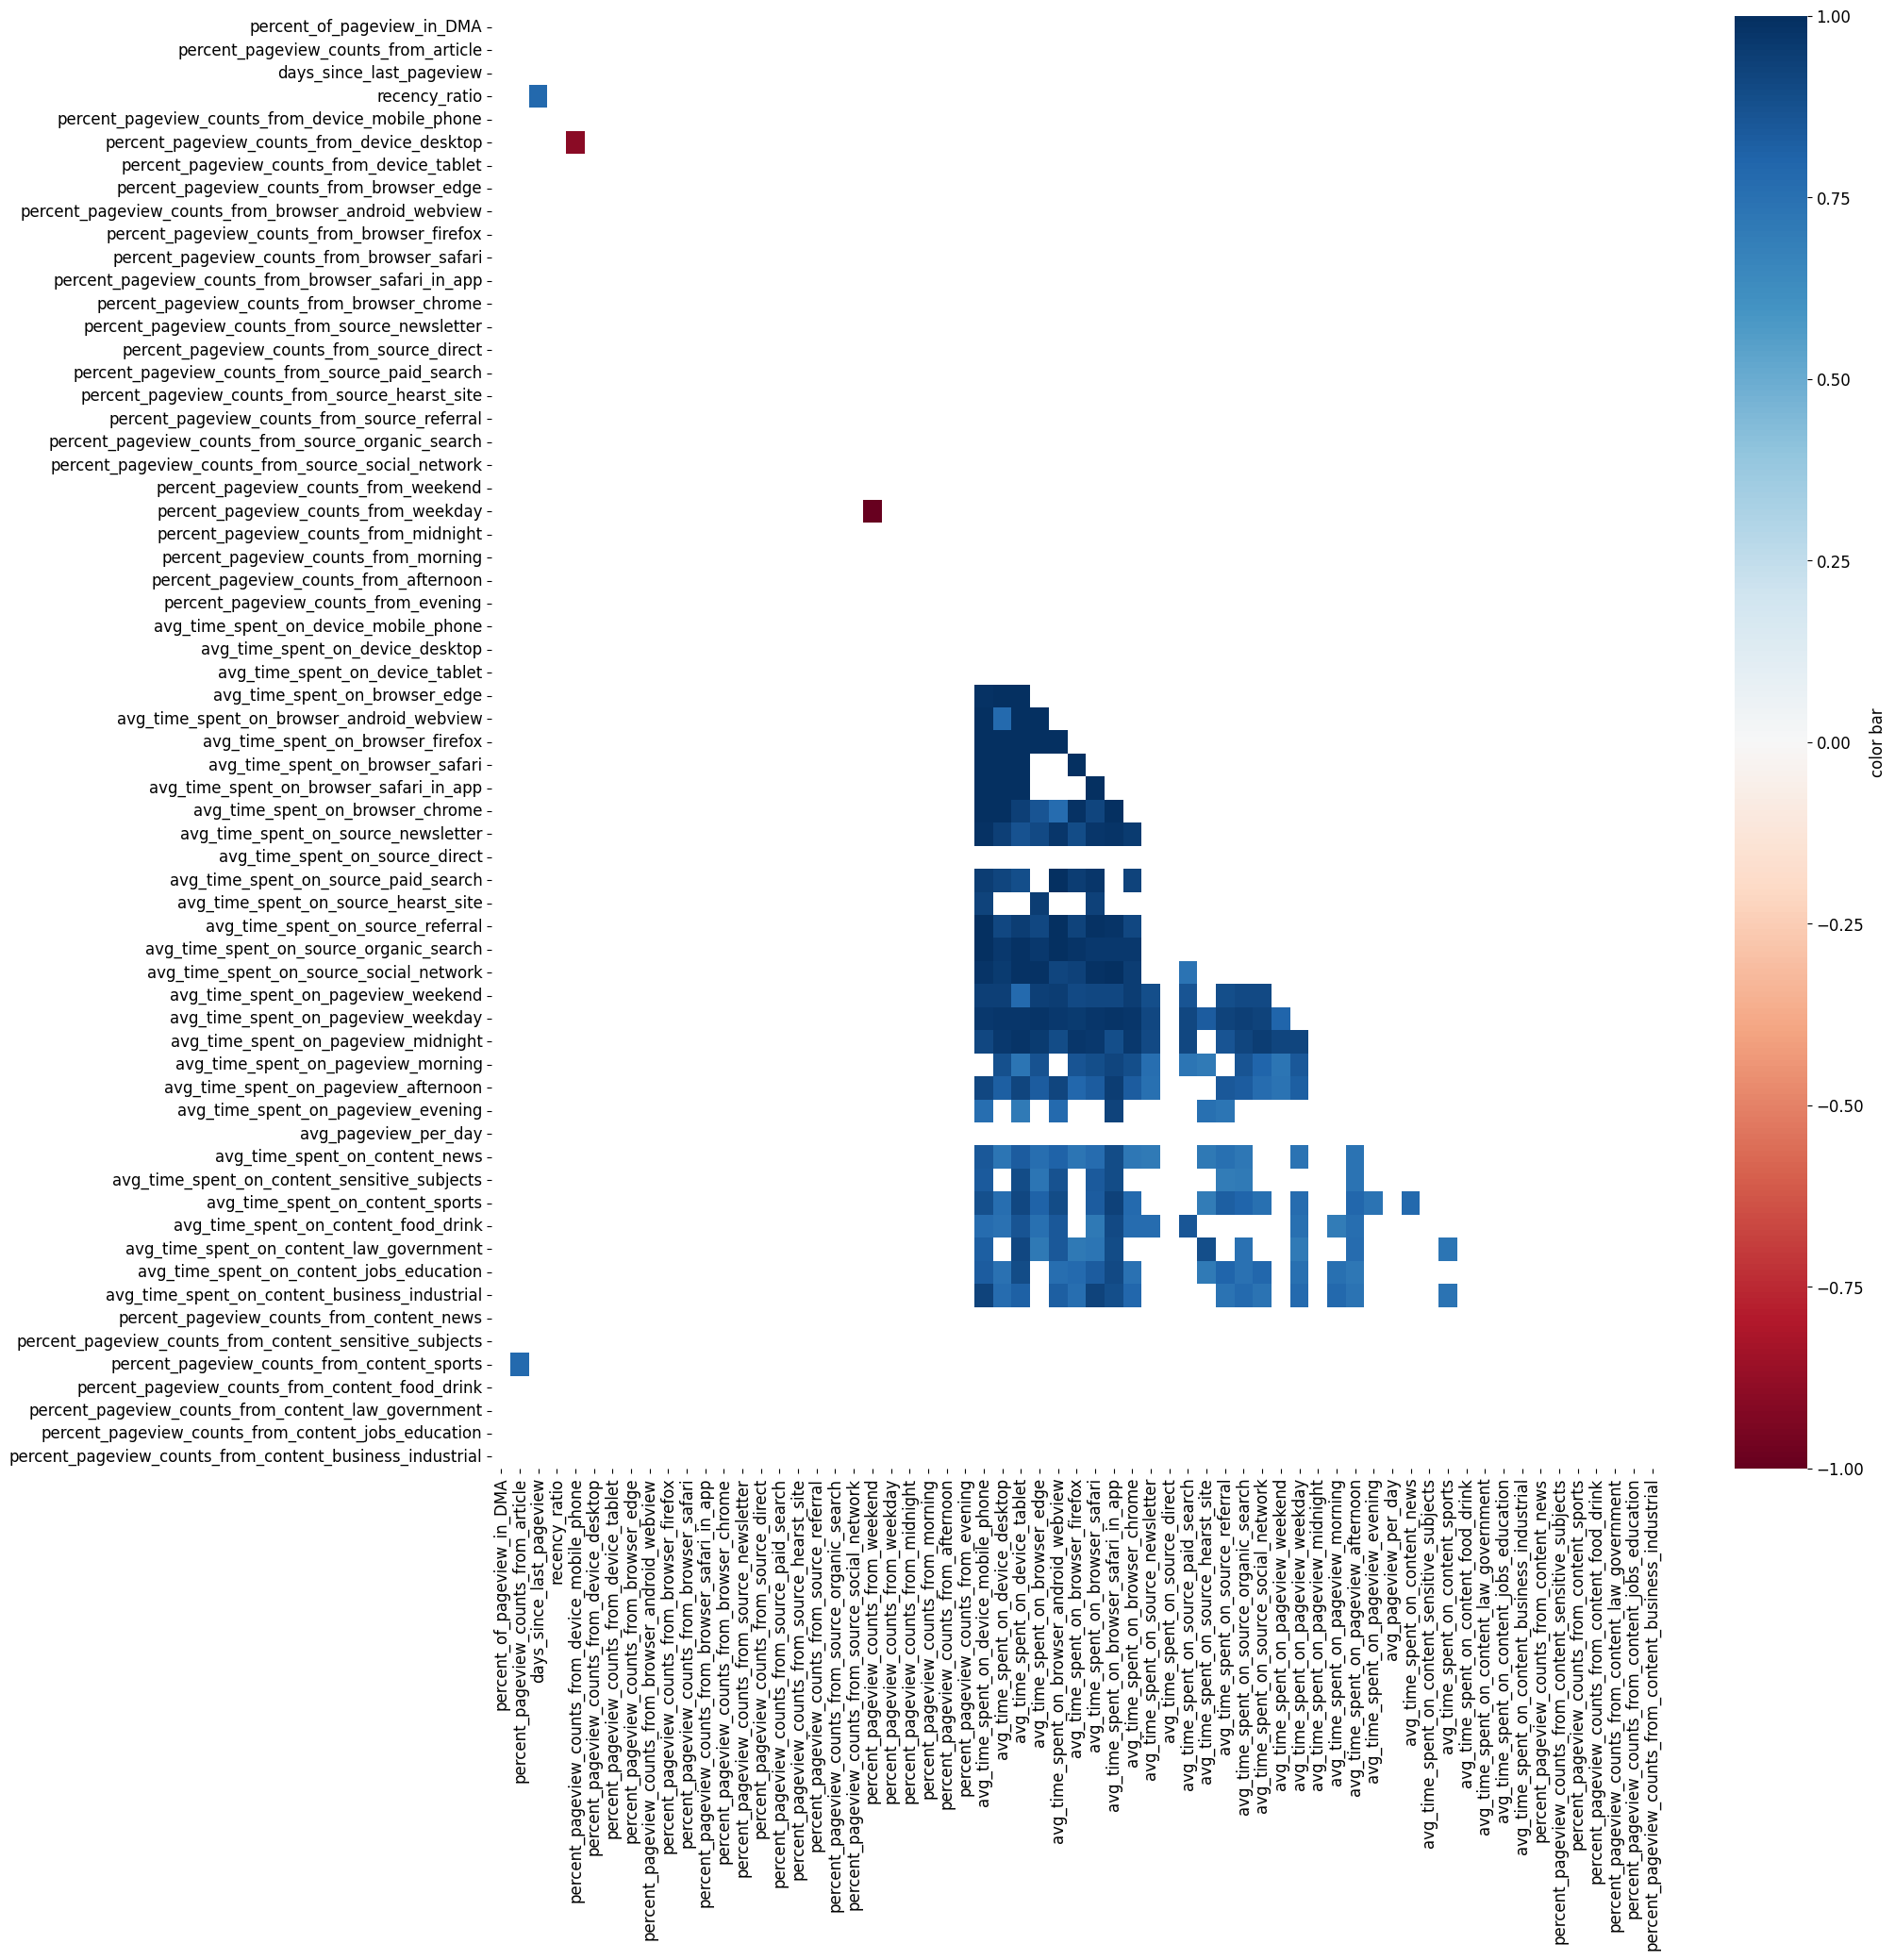

In [232]:
plot_heatmap(X, threshold = 0.7)

#### L1 Regularization

In [233]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [234]:
X.shape, y.shape

((2351946, 63), (2351946,))

In [235]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.

## TODO: what ist he baseline
eps = 0.0000001
clf = LassoCV(eps = 0.001, verbose = 1)
sfm = SelectFromModel(clf)
sfm.fit(X.fillna(0), y)

features = list(sfm.get_feature_names_out())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished


In [236]:
len(features)

2

In [237]:
X = X[features]

In [238]:
def plot_heatmap(df, threshold=0, figsize=(20, 20)):
    """Generate heatmap to visualize correlation among numerical features
    Args:
        df: (pd.DataFrame)
            dataframe to plot heat map on
        threshold: (float)
            threshold for the heatmap to filter based on in terms of magnitude
        figsize: (int, int)
            figsize for the visualization
    """
    # Generate correlation data
    corr = df.corr()

    # Create mask
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr[(corr >= abs(threshold)) | (corr <= -abs(threshold))],
        annot=True,
        cmap="RdBu",
        mask=mask,
        annot_kws={"size": 8},
        cbar_kws={"label": "color bar"},
    )
    plt.show()

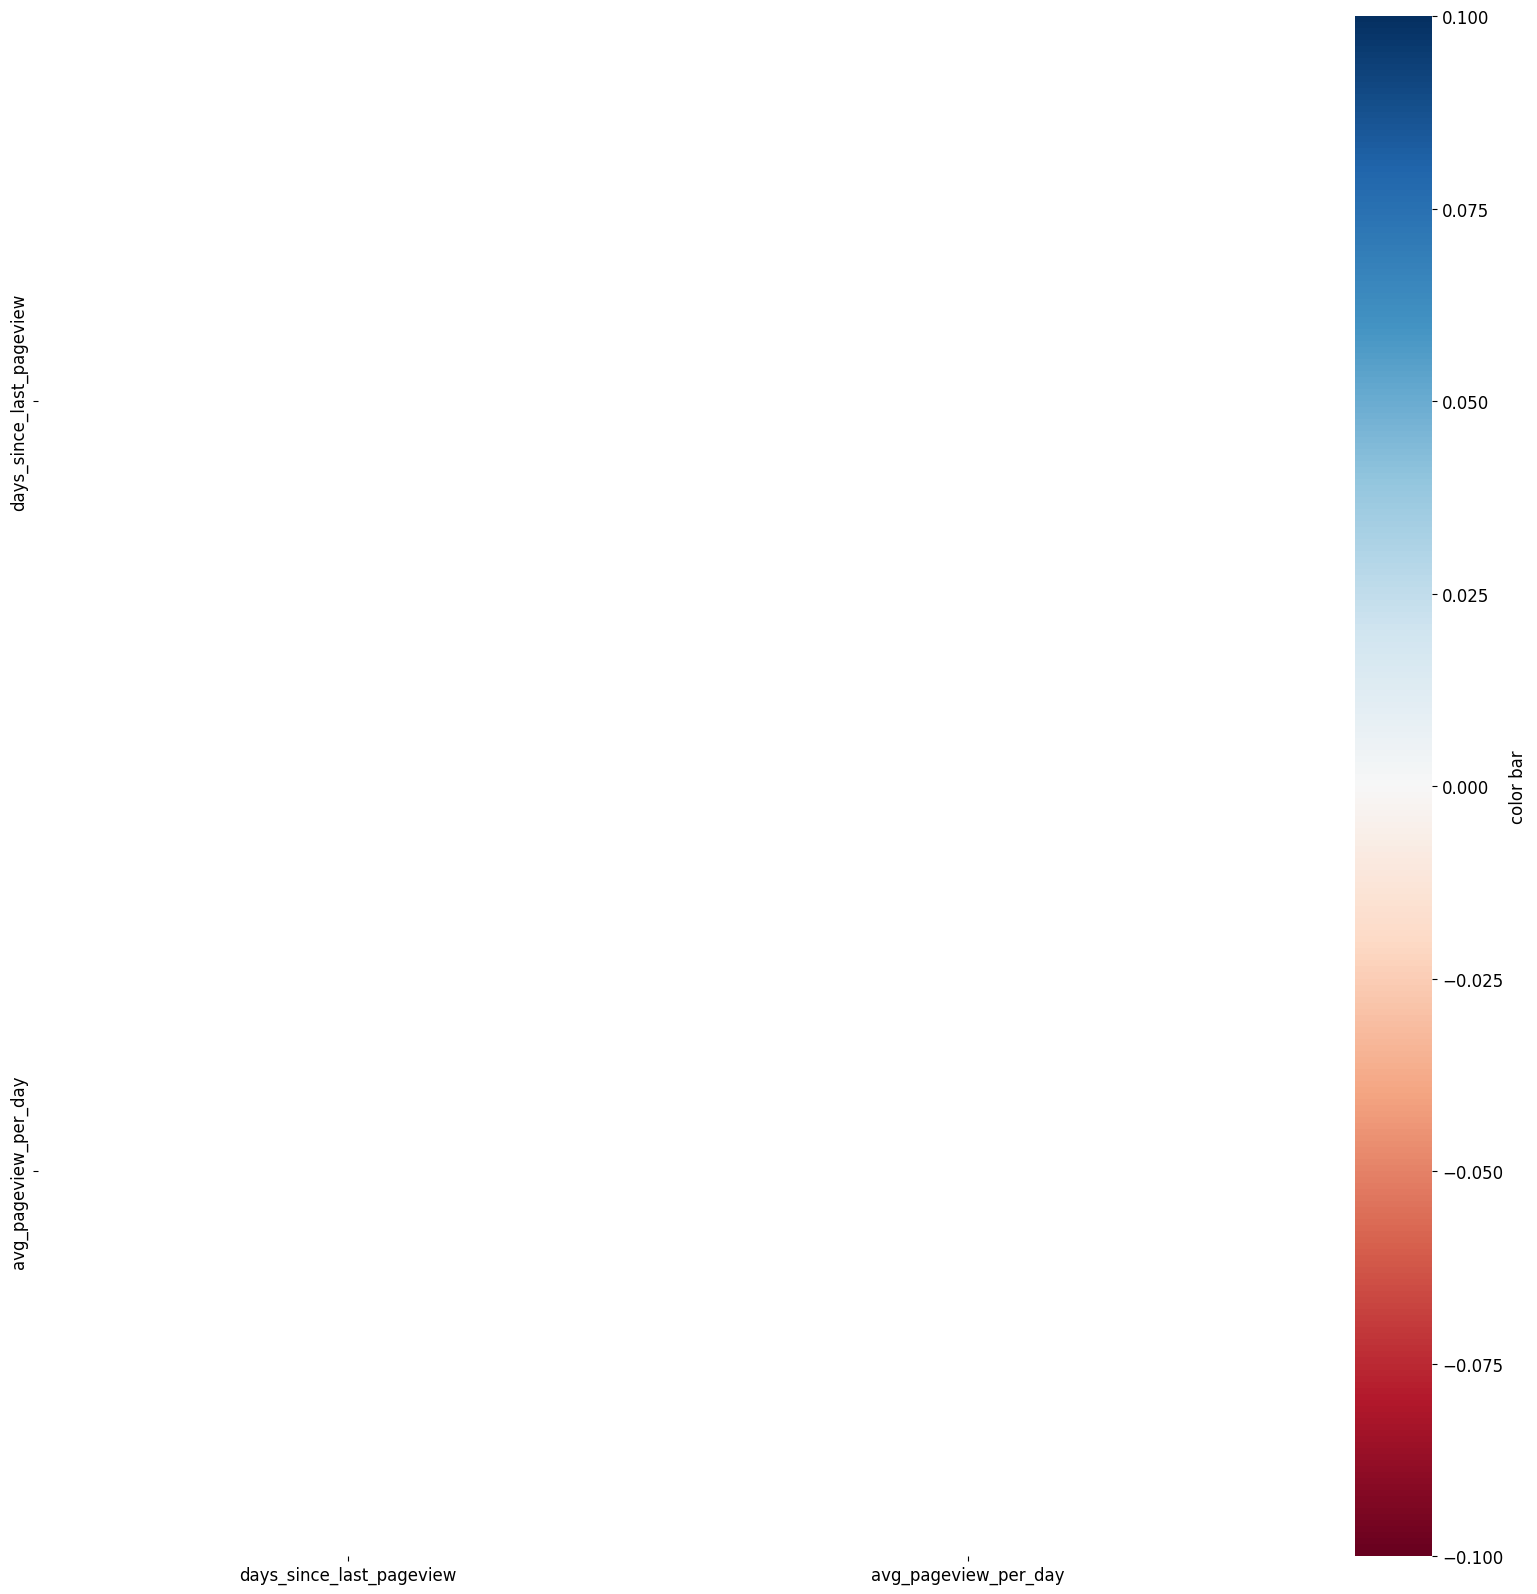

In [239]:
plot_heatmap(X.fillna(0), threshold = 0.7)

#### VIF

Most research papers consider a VIF (Variance Inflation Factor) > 10 as an indicator of multicollinearity, but some choose a more conservative threshold of 5 or even 2.5.
Source: https://quantifyinghealth.com/vif-threshold/

In [240]:
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X)

In [241]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.fillna(0).values, i)
                          for i in range(len(X.columns))]

In [242]:
len(vif_data[vif_data['VIF'] > 10]), len(vif_data)

(0, 2)

In [243]:
vif_data[vif_data['VIF'] > 10]

,feature,VIF


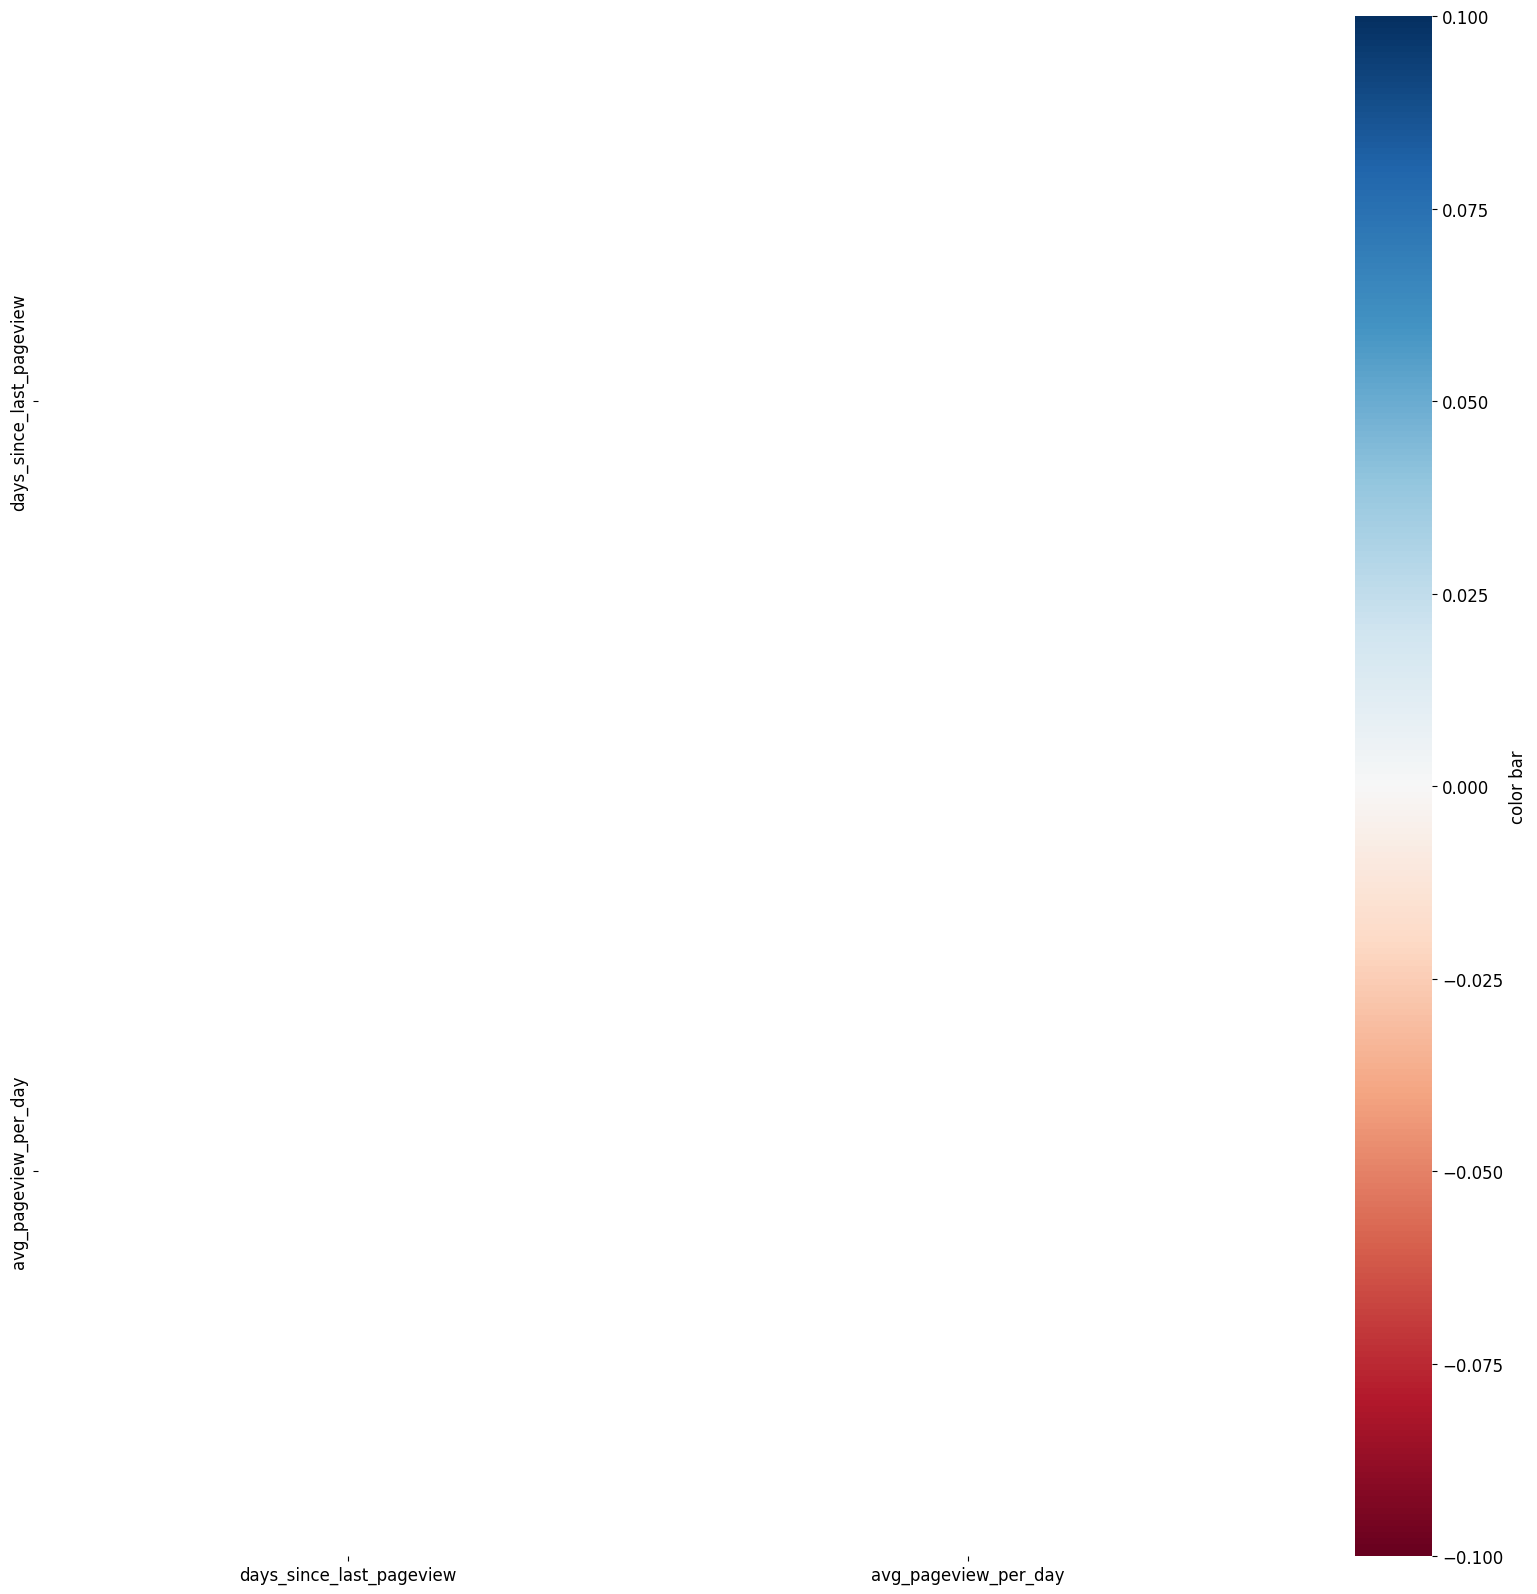

In [244]:
plot_heatmap(X.fillna(0), threshold = 0.7)

#### Cleaning up for Modeling

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size = 0.33, stratify=y, random_state=42)

### XGBoost

In [246]:
## TODO: hyperparameter tuning
clf = xgb.XGBClassifier()
calibrated_xgb = CalibratedClassifierCV(clf, method='isotonic', cv=3)
calibrated_xgb.fit(X_train, y_train)
y_prob_calibrated = calibrated_xgb.predict_proba(X_test)

<Figure size 800x600 with 0 Axes>

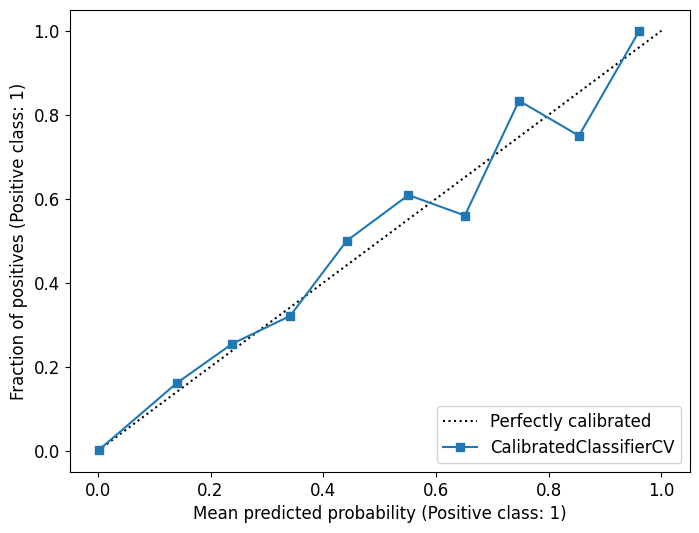

In [247]:
plt.clf()
disp = CalibrationDisplay.from_estimator(calibrated_xgb, X_test, y_test, n_bins=10)

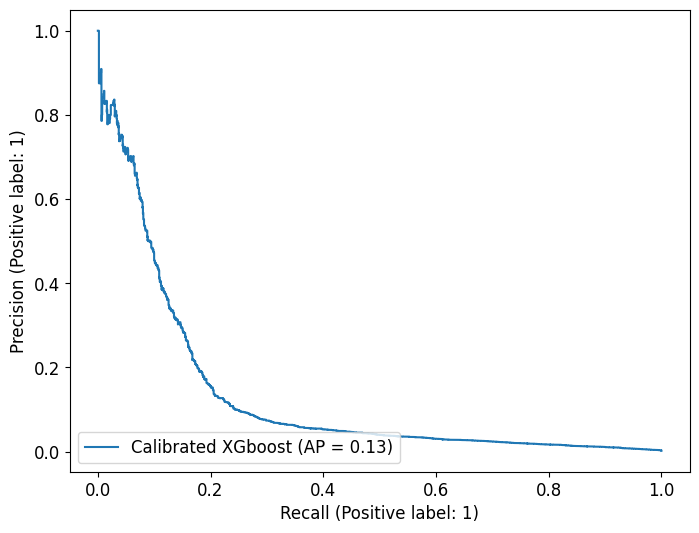

In [248]:
display = PrecisionRecallDisplay.from_estimator(
    calibrated_xgb, X_test, y_test, name="Calibrated XGboost"
)

In [249]:
average_precision_score(y_test, y_prob_calibrated[:, 1])

0.13062672524368718

In [250]:
store = []
for i in range(3):
    store.append(calibrated_xgb.calibrated_classifiers_[i].base_estimator.feature_importances_)

feature_importance = np.mean(store, axis=0)
feature_important = {key:val for key, val in zip(list(X.columns), feature_importance)}

keys = list(feature_important.keys())
values = list(feature_important.values())

features_df_xgb = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
features_df_xgb.nlargest(20, columns="score").sort_values(by = 'score', ascending=True).plot(kind='barh', figsize = (12,10), title = 'Top features based on feature importance')
plt.show()

AttributeError: '_CalibratedClassifier' object has no attribute 'base_estimator'

In [251]:
df.head()

,unique_visitor_id,percent_of_pageview_in_DMA,percent_pageview_counts_from_article,percent_time_on_site_from_article,days_to_subscription,days_since_first_pageview,days_since_last_pageview,recency_ratio,total_pageview_counts,percent_pageview_counts_from_device_mobile_phone,...,percent_pageview_counts_from_content_business_industrial,percent_time_spent_on_content_null,percent_time_spent_on_content_news,percent_time_spent_on_content_sensitive_subjects,percent_time_spent_on_content_sports,percent_time_spent_on_content_food_drink,percent_time_spent_on_content_law_government,percent_time_spent_on_content_jobs_education,percent_time_spent_on_content_business_industrial,has_subscribed
0,65195311-7562394252569080026,0.25,0.500000,0.767485,NaN,59,51,376.125,8,0.0,...,NaN,0.232515,NaN,0.249016,NaN,NaN,NaN,NaN,NaN,0
1,65195311-1777229465575295678,1.00,0.333333,0.272727,NaN,32,18,192.000,3,0.0,...,NaN,0.727273,NaN,NaN,NaN,NaN,0.272727,NaN,NaN,0
2,65195311-8125490054488688187,1.00,1.000000,1.000000,NaN,72,72,5184.000,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,65195311-3342248039944515107,0.00,1.000000,1.000000,NaN,0,0,NaN,2,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
4,65195311-854183054555717188,1.00,1.000000,1.000000,NaN,36,36,648.000,2,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0


### Concatenate the probability prediction

In [252]:
df = df[list(X.columns) + ['has_subscribed'] + ['percent_of_pageview_in_DMA']]
calibrated_xgb.fit(X, y)
df['prob_calibrated'] = calibrated_xgb.predict_proba(X)[:, 1]

In [253]:
## Take a look at the average
df[['prob_calibrated']].mean()

prob_calibrated    0.002016
dtype: float64

In [254]:
df.head(20)

,days_since_last_pageview,avg_pageview_per_day,has_subscribed,percent_of_pageview_in_DMA,prob_calibrated
0,51,0.135593,0,0.25,0.001956
1,18,0.093750,0,1.00,0.001704
2,72,0.013889,0,1.00,0.000000
3,0,NaN,0,0.00,0.000000
4,36,0.055556,0,1.00,0.000231
5,17,0.235294,0,0.00,0.001951
6,0,NaN,0,1.00,0.000000
7,7,0.142857,0,0.00,0.001610
8,65,0.027778,0,1.00,0.000000
9,71,0.014085,0,1.00,0.000000


# Matching
Source:
1. http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html

2. https://matheusfacure.github.io/python-causality-handbook/10-Matching.html



#### Pre-matching

In [255]:
## Drop users with mixed pageview -- only use those 100% in-market or our-of-market
df = df[df['percent_of_pageview_in_DMA'].isin([1.0, 0.0])]
df['treatment'] = df['percent_of_pageview_in_DMA'].apply(lambda x: 0 if x < 0.5 else 1)

In [256]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    """
    Calculate standardized mean differences.
    """
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})

In [257]:
## Create table one dataset
features = df.columns.tolist()

## remove treatment and outcome variable
#features.remove('treatment')
features.remove('prob_calibrated')
features.remove('has_subscribed')
features.remove('percent_of_pageview_in_DMA')

In [258]:
## Aggregation operations
#agg_operations = {'treatment': 'count'}
#agg_operations.update({
#    feature: ['mean', 'std'] for feature in features
#})

#table_one = df.groupby('treatment').agg(agg_operations)
#table_one.head()

In [259]:
#table_one_smd = compute_table_one_smd(table_one)
#table_one_smd

In [260]:
## pre-matching smd
#(table_one_smd['smd'] > 0.1).sum()

In [261]:
## pre-matching smd
#(table_one_smd['smd'] > 0.2).sum()

### Generate Propensity Score

Generate propensity score for propensity score matching

In [262]:
probability = df['prob_calibrated']
has_subscribed = df['has_subscribed']
treatment = df['treatment']
df_prop = df.drop(['has_subscribed', 'treatment', 'percent_of_pageview_in_DMA','prob_calibrated']
                  , axis=1)

df_prop = df_prop.fillna(0)

In [263]:
column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), list(df_prop.columns))],
    sparse_threshold=0,
    remainder='passthrough'
)

data = column_transformer.fit_transform(df_prop)
data.shape

(2300965, 2)

In [264]:
## Logistic regression
## TODO: We already know that logistic regression might not be the best model.
## any other way to get propensity score? 
logistic = LogisticRegression(verbose = 1)
logistic.fit(data, treatment)
pscore = logistic.predict_proba(data)[:, 1]
pscore

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59491D+06    |proj g|=  9.52666D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.445D-01   1.586D+06
  F =   1586415.3333212952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


array([0.52347648, 0.44227013, 0.54922194, ..., 0.51549082, 0.4555895 ,
       0.49741867])

In [265]:
## Check distribution
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (1131948,)
control count: (1169017,)


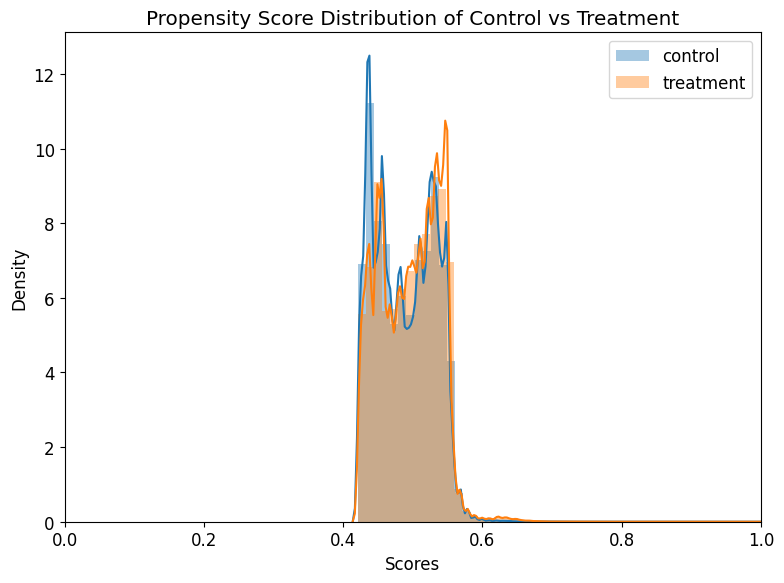

In [266]:
## Plot distribution
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

### Matching

Before matching, we can perform some trimming.

1. Get rid of individuals who have extreme propensity scores.


In [267]:
len(neg_pscore), len(pos_pscore)

(1169017, 1131948)

In [268]:
## removing control subjects whose propensity score is less than the minimum in the treatment group,
neg_pscore_new = neg_pscore[np.where(neg_pscore >= pos_pscore.min())[0]]

## removing treated subjects whose propensity score is greater than the maximum in the control group.
pos_pscore_new = pos_pscore[np.where(pos_pscore <= neg_pscore.max())[0]]

In [269]:
len(neg_pscore_new), len(pos_pscore_new)

(1169017, 1131948)

2. **Calipar (threshold) matching**: only consider the treatment and control subject to be a match if the difference between their propensity score difference is less than a specified threshold

In [270]:
## TODO: this is also one hyperparameter we should think about
## How does changing this caliper affect the quality of matching / result for the model?
caliper = 0.000001

In [271]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=-1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[116026],
       [   140],
       [  5485],
       ...,
       [  1417],
       [   501],
       [   154]])

In [272]:
## Filter based on caliper
indx = np.where(sim_distances < caliper)[0]
sim_distances_filtered = sim_distances[indx]
sim_indices_filtered = sim_indices[indx]

In [273]:
df_prop['treatment'] = treatment
df_prop['probability'] = probability
df_prop['has_subscribed'] = has_subscribed

## Gather positive samples and negative samples survived after matching
df_pos = df_prop[mask].iloc[indx]
df_neg = df_prop[~mask].iloc[sim_indices_filtered[:, 0]]

## Create dataframe after matching
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,days_since_last_pageview,avg_pageview_per_day,treatment,probability,has_subscribed
1,18,0.093750,1,0.001704,0
2,72,0.013889,1,0.000000,0
4,36,0.055556,1,0.000231,0
6,0,0.000000,1,0.000000,0
8,65,0.027778,1,0.000000,0


In [274]:
## Prior to matching, how many datapoints do we have?
df_prop['has_subscribed'].value_counts()

0    2296725
1       4240
Name: has_subscribed, dtype: int64

In [275]:
## After matching, how many datapoints do we have?
df_matched['has_subscribed'].value_counts()

0    2137248
1       3830
Name: has_subscribed, dtype: int64

In [276]:
## How many datapoints left?
len(df_matched) / len(df_prop)

0.9305130673434842

### Post-matching

We also calculate stadardized differences to evaluate post-matching dataset.

In [277]:
table_one_matched = df_matched.groupby('treatment').agg(agg_operations)
table_one_matched.head()

NameError: name 'agg_operations' is not defined

In [ ]:
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

In [ ]:
## pre-matching smd
(table_one_smd_matched['smd'] > 0.1).sum()

In [ ]:
## post-matching smd
(table_one_smd_matched['smd'] > 0.2).sum()

## Modeling

Source: 

1. https://quantifyinghealth.com/interpret-logistic-regression-coefficients/

2. https://www.andrewvillazon.com/logistic-regression-python-statsmodels/

3. https://matheusfacure.github.io/python-causality-handbook/18-Heterogeneous-Treatment-Effects-and-Personalization.html

### Logit Model for Average Treatment Effect

The coefficient for the **treatment** in the summary table is the average treatment effect in log odds form.

In [278]:
string = ""
for val in list(df_matched.columns[:-3]):
    string += f" + {val}"

In [312]:
df_matched

,days_since_last_pageview,avg_pageview_per_day,treatment,probability,has_subscribed,S_Learner_CATE,S_Learner_uplift,T_Learner_CATE,T_Learner_uplift
1,18,0.093750,1,0.001704,0,0.000780,0.457992,0.000176,0.103003
2,72,0.013889,1,0.000000,0,0.000031,NaN,-0.000023,NaN
4,36,0.055556,1,0.000231,0,0.000349,1.511996,0.000817,3.537080
6,0,0.000000,1,0.000000,0,-0.000136,NaN,0.000036,NaN
8,65,0.027778,1,0.000000,0,0.000031,NaN,-0.000034,NaN
...,...,...,...,...,...,...,...,...,...
10569,20,0.150000,0,0.000523,0,0.001131,2.162966,0.001591,3.043510
173,19,0.157895,0,0.000568,0,0.001366,2.402524,0.002853,5.019091
2810,82,0.024390,0,0.000000,0,0.000031,NaN,-0.000034,NaN
1030,23,0.043478,0,0.000361,0,0.000760,2.105567,0.001299,3.598412


In [279]:
func = f"has_subscribed ~ treatment{string}"

In [280]:
func

'has_subscribed ~ treatment + days_since_last_pageview + avg_pageview_per_day'

In [281]:
model = smf.logit(func, data=df_matched).fit(maxiter = 1000)

Optimization terminated successfully.
         Current function value: 0.012321
         Iterations 12


In [282]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:         has_subscribed   No. Observations:              2141078
Model:                          Logit   Df Residuals:                  2141074
Method:                           MLE   Df Model:                            3
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.05974
Time:                        14:46:40   Log-Likelihood:                -26380.
converged:                       True   LL-Null:                       -28056.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -5.3492      0.029   -183.425      0.000      -5.406      -5.292
treatment                    0.1581      0.032      4.866      0.000       0.094       0.

In [311]:
## odds ratio for the treatment
np.exp(0.9391)

2.557678471534282

Which means 
1. The treatment group has 2.56 times the odds of control group of subscription
2. Treatment multiplies by 2.56 the probability of subscription compared to control.

### Logit model for Heterogeneous Treatment effect

We include interaction terms to see the heterogeneous treatment effect.

In [284]:
string = ""
for val in list(df_matched.columns[:-3]):
    string += f"{val} + "
for val in list(df_matched.columns[:-3]):
    string += f"treatment*{val} + "

In [285]:
func = f"has_subscribed ~ treatment + {string[:-3]}"

In [286]:
func

'has_subscribed ~ treatment + days_since_last_pageview + avg_pageview_per_day + treatment*days_since_last_pageview + treatment*avg_pageview_per_day'

In [287]:
model = smf.logit(func, data=df_matched).fit(maxiter = 1000)

Optimization terminated successfully.
         Current function value: 0.012317
         Iterations 12


In [288]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:         has_subscribed   No. Observations:              2141078
Model:                          Logit   Df Residuals:                  2141072
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                 0.06003
Time:                        14:46:44   Log-Likelihood:                -26372.
converged:                       True   LL-Null:                       -28056.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -5.3907      0.035   -155.348      0.000      -5.459      -5.323
treatment                              0.2327      0.047   

people with 100% from desktop, 100% from newsletter, 100% in morning, 100% reading news

In [289]:
## Example: people with 100% from desktop, 100% from newsletter, 100% in morning, 100% reading news
np.exp(1.5098 + 0.2391 * 1 + (- 0.2506) + (-0.0250) + 0.6636) ## odds

8.473130169865946

8.47 times more likely to subscribe (uplift)

In [290]:
## baseline 0.001
0.001 * 8.47 - 0.001

0.00747

In [291]:
## baseline: 0.02
0.02 * 8.47 - 0.02

0.14940000000000003

### S-Learner

Source: https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

In [292]:
df_matched

,days_since_last_pageview,avg_pageview_per_day,treatment,probability,has_subscribed
1,18,0.093750,1,0.001704,0
2,72,0.013889,1,0.000000,0
4,36,0.055556,1,0.000231,0
6,0,0.000000,1,0.000000,0
8,65,0.027778,1,0.000000,0
...,...,...,...,...,...
10569,20,0.150000,0,0.000523,0
173,19,0.157895,0,0.000568,0
2810,82,0.024390,0,0.000000,0
1030,23,0.043478,0,0.000361,0


In [293]:
from xgboost import XGBRegressor

X_slearner = df_matched.drop(columns = ['probability', 'has_subscribed'])
y_slearner = df_matched['has_subscribed']

s_learner = XGBRegressor()
s_learner.fit(X_slearner, y_slearner)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [294]:
s_learner_cate_train = (s_learner.predict(X_slearner.assign(treatment = 1)) -
                        s_learner.predict(X_slearner.assign(treatment = 0)))

s_learner_cate_train

array([7.8044250e-04, 3.0579948e-05, 3.4918863e-04, ..., 3.0579948e-05,
       7.5991510e-04, 3.0579948e-05], dtype=float32)

In [295]:
df_matched

,days_since_last_pageview,avg_pageview_per_day,treatment,probability,has_subscribed
1,18,0.093750,1,0.001704,0
2,72,0.013889,1,0.000000,0
4,36,0.055556,1,0.000231,0
6,0,0.000000,1,0.000000,0
8,65,0.027778,1,0.000000,0
...,...,...,...,...,...
10569,20,0.150000,0,0.000523,0
173,19,0.157895,0,0.000568,0
2810,82,0.024390,0,0.000000,0
1030,23,0.043478,0,0.000361,0


In [296]:
## Take a look at other learners as well

m0 = XGBRegressor()
m1 = XGBRegressor()

df0 = df_matched[df_matched['treatment'] == 0].copy()
df1 = df_matched[df_matched['treatment'] == 1].copy()

X0_tlearner = df0.drop(columns = ['probability', 'has_subscribed'])
y0_tlearner = df0['has_subscribed']

X1_tlearner = df1.drop(columns = ['probability', 'has_subscribed'])
y1_tlearner = df1['has_subscribed']

In [297]:
X0_tlearner

,days_since_last_pageview,avg_pageview_per_day,treatment
232891,18,0.093750,0
283,72,0.013889,0
10927,36,0.055556,0
3,0,0.000000,0
910764,65,0.027778,0
...,...,...,...
10569,20,0.150000,0
173,19,0.157895,0
2810,82,0.024390,0
1030,23,0.043478,0


In [298]:
m0.fit(X0_tlearner, y0_tlearner)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [299]:
m1.fit(X1_tlearner, y1_tlearner)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [300]:
# estimate the CATE
t_learner_cate_train = m1.predict(X_slearner) - m0.predict(X_slearner)

In [301]:
df_matched['S_Learner_CATE'] = s_learner_cate_train
df_matched['S_Learner_uplift'] = (df_matched['S_Learner_CATE'] / df_matched['probability']).replace(-np.inf, np.nan).replace(np.inf, np.nan)
df_matched['T_Learner_CATE'] = t_learner_cate_train
df_matched['T_Learner_uplift'] = (df_matched['T_Learner_CATE'] / df_matched['probability']).replace(-np.inf, np.nan).replace(np.inf, np.nan)

In [302]:
uplift = df_matched['S_Learner_uplift'][~np.isnan(df_matched['S_Learner_uplift'])]
(uplift >= 1).value_counts()

True     883502
False    582197
Name: S_Learner_uplift, dtype: int64

In [304]:
df_matched

,days_since_last_pageview,avg_pageview_per_day,treatment,probability,has_subscribed,S_Learner_CATE,S_Learner_uplift,T_Learner_CATE,T_Learner_uplift
1,18,0.093750,1,0.001704,0,0.000780,0.457992,0.000176,0.103003
2,72,0.013889,1,0.000000,0,0.000031,NaN,-0.000023,NaN
4,36,0.055556,1,0.000231,0,0.000349,1.511996,0.000817,3.537080
6,0,0.000000,1,0.000000,0,-0.000136,NaN,0.000036,NaN
8,65,0.027778,1,0.000000,0,0.000031,NaN,-0.000034,NaN
...,...,...,...,...,...,...,...,...,...
10569,20,0.150000,0,0.000523,0,0.001131,2.162966,0.001591,3.043510
173,19,0.157895,0,0.000568,0,0.001366,2.402524,0.002853,5.019091
2810,82,0.024390,0,0.000000,0,0.000031,NaN,-0.000034,NaN
1030,23,0.043478,0,0.000361,0,0.000760,2.105567,0.001299,3.598412


In [305]:
s_learner_uplift = np.nanmean(df_matched['S_Learner_uplift'])
t_learner_uplift = np.nanmean(df_matched['T_Learner_uplift'])

In [309]:
baseline = np.nanmean(df_matched['probability'])

In [306]:
s_learner_uplift

1.2202737282687497

In [307]:
t_learner_uplift

1.5484780877094528